## 1. Data

In [1]:
# Import
import pandas as pd
import math
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [2]:
df = pd.read_csv('stock_price_with_indicators.csv', index_col = 'Date')
df.head()

,Close,Open,High,Low,Vol,Change_%,SMA_20,EMA_20,BB_upper_20,BB_lower_20,OBV,MACD_12_26,MACDsign_12_26,MACDdiff_12_26,RSI_14
Date,,,,,,,,,,,,,,,
"Dec 30, 2020",124.34,123.74,124.82,123.63,3380494,0.44,124.8410,123.945514,127.033580,122.648420,-3487007.0,0.865134,1.227020,-0.361885,46.736086
"Dec 29, 2020",123.80,125.25,125.48,123.25,3487007,-0.82,124.7820,123.903989,127.091720,122.472280,128215.0,0.937666,1.317491,-0.379825,46.736086
"Dec 28, 2020",124.82,125.12,126.57,124.46,3615222,0.10,124.7680,123.914935,127.106003,122.429997,-1632907.0,1.071586,1.412447,-0.340861,48.493620
"Dec 24, 2020",124.69,125.00,125.10,124.21,1761122,0.64,124.7445,123.819665,127.089739,122.399261,-4326796.0,1.123076,1.497662,-0.374587,44.856413
"Dec 23, 2020",123.90,123.93,125.16,123.89,2693889,0.23,124.7200,123.728051,127.077840,122.362160,-8664553.0,1.185696,1.591309,-0.405613,45.234450


In [3]:
df.index

Index(['Dec 30, 2020', 'Dec 29, 2020', 'Dec 28, 2020', 'Dec 24, 2020',
       'Dec 23, 2020', 'Dec 22, 2020', 'Dec 21, 2020', 'Dec 18, 2020',
       'Dec 17, 2020', 'Dec 16, 2020',
       ...
       'Apr 18, 2001', 'Apr 17, 2001', 'Apr 16, 2001', 'Apr 12, 2001',
       'Apr 11, 2001', 'Apr 10, 2001', 'Apr 09, 2001', 'Apr 06, 2001',
       'Apr 05, 2001', 'Apr 04, 2001'],
      dtype='object', name='Date', length=4967)

In [4]:
df.index = pd.to_datetime(df.index, errors='coerce')
df.index

DatetimeIndex(['2020-12-30', '2020-12-29', '2020-12-28', '2020-12-24',
               '2020-12-23', '2020-12-22', '2020-12-21', '2020-12-18',
               '2020-12-17', '2020-12-16',
               ...
               '2001-04-18', '2001-04-17', '2001-04-16', '2001-04-12',
               '2001-04-11', '2001-04-10', '2001-04-09', '2001-04-06',
               '2001-04-05', '2001-04-04'],
              dtype='datetime64[ns]', name='Date', length=4967, freq=None)

In [5]:
# Lấy giá đóng mỗi ngày, EMA và 'RSI'
# Lý do lấy EMA và RSI là vì EMA có mối liên hệ với giá rất lớn
# và nhóm đã thử kết hợp EMA và các indicator khác thì RSI hoạt động tốt nhất
EMA_df = df[['Close', 'EMA_20', 'RSI_14']]
EMA_df = EMA_df.iloc[::-1]
EMA_df.head()

,Close,EMA_20,RSI_14
Date,,,
2001-04-04,92.00,95.854794,51.752593
2001-04-05,98.21,96.079099,52.086958
2001-04-06,97.95,96.257280,54.626714
2001-04-09,96.00,96.232777,50.149056
2001-04-10,99.05,96.501084,52.381700


In [6]:
# Chuyển về dạng numpy
dataset = EMA_df[['Close', 'EMA_20', 'RSI_14']].values
dataset[:5]

array([[92.        , 95.85479381, 51.75259348],
       [98.21      , 96.07909916, 52.08695767],
       [97.95      , 96.25728019, 54.62671353],
       [96.        , 96.23277731, 50.14905579],
       [99.05      , 96.50108424, 52.38170023]])

In [7]:
len(dataset)

4967

In [8]:
# Mỗi dòng của X là data của 60 ngày trước, mỗi dòng của y là giá của ngày đó
X, y = [], []
for i in range(60, len(dataset)):
  X.append(dataset[i-60:i][:])
  y.append(dataset[i][0])

In [9]:
# Chia train:val:test theo tỉ lệ 8:1:1
X_train, y_train = np.array(X[:math.ceil(len(X)*0.8)]), np.array(y[:math.ceil(len(X)*0.8)])
X_val, y_val = np.array(X[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)]), np.array(y[math.ceil(len(X)*0.8):math.ceil(len(X)*0.9)])
X_test, y_test = np.array(X[math.ceil(len(X)*0.9):]), np.array(y[math.ceil(len(X)*0.9):])

In [10]:
print("Size train: ", X_train.shape)
print("Size validate: ", X_val.shape)
print("Size test: ", X_test.shape)

Size train:  (3926, 60, 3)
Size validate:  (491, 60, 3)
Size test:  (490, 60, 3)


## 2. Model

Ở đây nhóm dùng 2 tầng LSTM 50 unit, sau đó là 1 tầng Dense 20 unit, output tầng Dense 1 unit.

In [11]:
#LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], 3)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))

In [12]:
model.compile(optimizer='adam', loss = 'mean_squared_error')

Ta sẽ chạy model 20 epoch để xem quá trình huấn luyện và biết khi nào model overfit.

In [13]:
#Train the model
hist = model.fit(X_train, y_train, batch_size=32, epochs=20, shuffle=True, validation_data=(X_val, y_val))

Epoch 1/20
123/123 [==============================] - 6s 49ms/step - loss: 11586.0742 - val_loss: 6567.3062
Epoch 2/20
123/123 [==============================] - 5s 42ms/step - loss: 2823.9966 - val_loss: 964.3093
Epoch 3/20
123/123 [==============================] - 6s 46ms/step - loss: 1463.3672 - val_loss: 244.3671
Epoch 4/20
123/123 [==============================] - 5s 42ms/step - loss: 270.0595 - val_loss: 87.2042
Epoch 5/20
123/123 [==============================] - 6s 46ms/step - loss: 79.8607 - val_loss: 65.2232
Epoch 6/20
123/123 [==============================] - 6s 45ms/step - loss: 32.1306 - val_loss: 48.2736
Epoch 7/20
123/123 [==============================] - 6s 45ms/step - loss: 20.6332 - val_loss: 31.4031
Epoch 8/20
123/123 [==============================] - 7s 55ms/step - loss: 12.4425 - val_loss: 27.3182
Epoch 9/20
123/123 [==============================] - 5s 43ms/step - loss: 9.8856 - val_loss: 15.9320
Epoch 10/20
123/123 [==============================] - 5s 43ms

In [14]:
hist.history['loss']

[11586.07421875,
 2823.99658203125,
 1463.3671875,
 270.0594787597656,
 79.8606948852539,
 32.13063049316406,
 20.633228302001953,
 12.442476272583008,
 9.885649681091309,
 9.852192878723145,
 8.567720413208008,
 7.130993843078613,
 6.318363189697266,
 6.4784464836120605,
 5.306426525115967,
 4.732668399810791,
 5.1322736740112305,
 5.53228759765625,
 4.522674083709717,
 4.104363918304443]

**Lịch sử huấn luyện**

Bởi vì model không được scale về 0-1 (vì giá có thể lên cao nữa nên nhóm quyết định không scale data) nên loss chênh lệch rất lớn, vì vậy khi biểu diễn nhóm thêm 'log' yscale để thể hiện rõ hơn quá trình huấn luyện

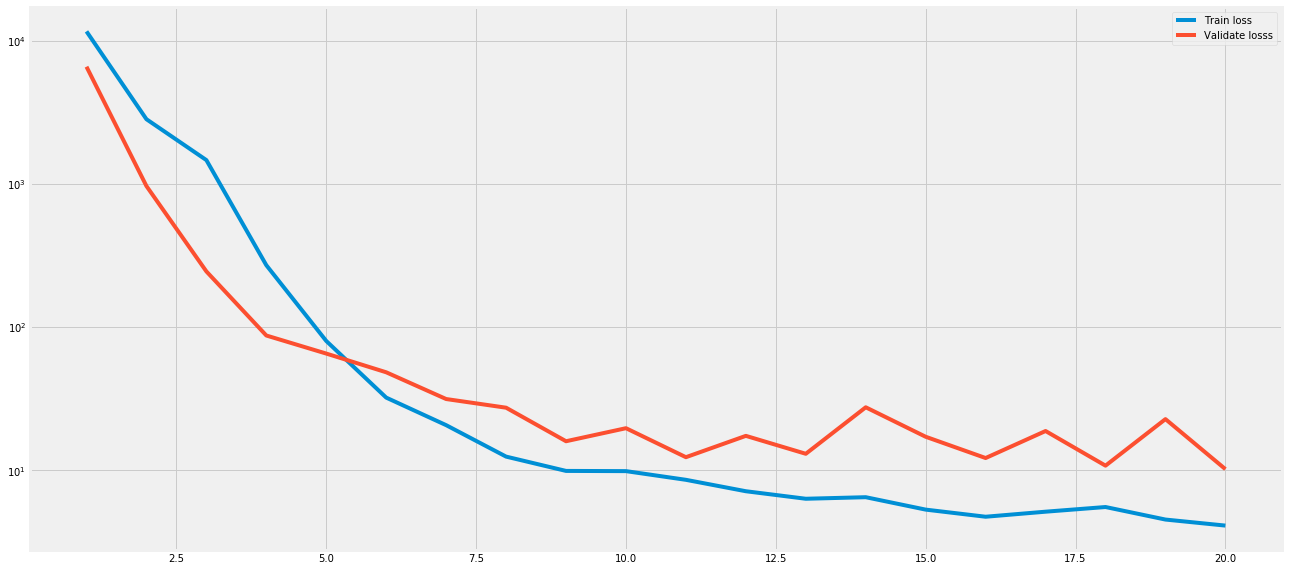

In [15]:
plt.figure(figsize = (20, 10))
plt.plot(np.arange(1, 21), hist.history['loss'])
plt.plot(np.arange(1, 21), hist.history['val_loss'])
plt.legend(['Train loss', 'Validate losss'], loc = 'upper right')
plt.yscale('log')
plt.show()

Theo biểu đồ và nhiều lần chạy thì nhóm quyết định khảo sát dừng ở epoch 10. Lý do là vì model có loss chấp nhận được và không bị quá fit dữ liệu.

## 3. Đánh giá model

Để công bằng ta sẽ chạy model 20 lần rồi lấy trung bình các chỉ số.

Ở đây ta có train loss, validate loss, test loss, rmse, correct direction, profit.

**Giải thích:**
- Rmse: Root mean square error (căn trung bình độ lỗi bình phương)
- Correct direction: Hướng (lên hoặc xuống) chính xác
- Profit: Giả định khi model báo giá lên ta mua vào (hoặc bán ra) 1 đồng coin (nếu giá 10\\$ thì mua 10\\$, giá 100\\$ thì mua 100\\$). Ta sẽ bán vào giá đóng của ngày hôm sau. Lời lỗ từ đó mà tính ra.

In [16]:
# Comment cell này nếu không cần đánh giá trung bình 20 lần chạy vì sẽ rất lâu
indexes = {'train':[], 'val': [], 'test': [], 'rmse': [], 'correct_direction': [], 'profit': []}
iteration = 20
for i in range(iteration):
    # Model
    model = Sequential()
    model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], 3)))
    model.add(LSTM(50, return_sequences=False))
    model.add(Dense(20, activation=None))
    model.add(Dense(1, activation=None))
    model.compile(optimizer='adam', loss = 'mean_squared_error')
    # Fit
    hist = model.fit(X_train, y_train, batch_size=32, epochs=10, shuffle=True, validation_data=(X_val, y_val), verbose=0)
    # Lấy train loss và validate loss
    indexes['train'].append(hist.history['loss'][-1])
    indexes['val'].append(hist.history['val_loss'][-1])
    # Lấy test loss
    test_loss = model.evaluate(X_test, y_test, batch_size=32)
    indexes['test'].append(test_loss)
    # Lấy prediction để tính rmse, số lượng correct direcion và profit theo giả thuyết
    predictions = model.predict(X_test)
    predictions = predictions.reshape((1, -1))[0]
    rmse = np.sqrt(np.mean((predictions - y_test)**2))
    indexes['rmse'].append(rmse)
    correct_direction = 0
    for j in range(1, len(X_test)):
        if (predictions[j] > y_test[j - 1] and y_test[j] > y_test[j - 1]) or (predictions[j] < y_test[j - 1] and y_test[j] < y_test[j - 1]):
            correct_direction += 1
    indexes['correct_direction'].append(correct_direction/(len(X_test) - 1))
    profit = 0
    for j in range(1, len(X_test)):
        if predictions[j] > y_test[j-1]:
            profit += (y_test[j] - y_test[j-1])
        else:
            profit += (y_test[j-1] - y_test[j])
    indexes['profit'].append(profit)
for value in indexes:
    print(value, sum(indexes[value])/iteration)

16/16 [==============================] - 0s 16ms/step - loss: 20.6976
train 8.156914615631104
val 15.311462640762329
test 15.471965456008911
rmse 3.8830110927649573
correct_direction 0.6070552147239263
profit 244.69499999999985


**Kết quả:**
- train 8.156914615631104
- val 15.311462640762329
- test 15.471965456008911
- rmse 3.8830110927649573
- correct_direction 0.6070552147239263
- profit 244.69499999999985

**Kết luận:** Sau 20 lần chạy (khoảng 20 phút), 61% hướng dự đoán đúng quá tốt (vượt qua mong đợi của nhóm), rmse 3.9 và test loss 15.5 khá tốt. Thí nghiệm cho lợi nhuận 244\\$ sau hơn 400 ngày, quá ổn (với vốn > 100\\$ và < 200$).

**Ta sẽ chạy 1 lần nữa để vẽ biểu đồ giá dự đoán**

In [18]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape = (X_train.shape[1], 3)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(20, activation=None))
model.add(Dense(1, activation=None))
model.compile(optimizer='adam', loss = 'mean_squared_error')
model.fit(X_train, y_train, batch_size=32, epochs=10, shuffle=True, validation_data=(X_val, y_val))
predictions = model.predict(X_test)
predictions = predictions.reshape((1, -1))[0]

Epoch 1/10
123/123 [==============================] - 6s 47ms/step - loss: 11264.9111 - val_loss: 5712.7949
Epoch 2/10
123/123 [==============================] - 5s 43ms/step - loss: 2519.5002 - val_loss: 805.6431
Epoch 3/10
123/123 [==============================] - 5s 43ms/step - loss: 1675.9547 - val_loss: 532.4152
Epoch 4/10
123/123 [==============================] - 5s 41ms/step - loss: 396.4681 - val_loss: 41.2175
Epoch 5/10
123/123 [==============================] - 5s 44ms/step - loss: 62.3146 - val_loss: 31.2021
Epoch 6/10
123/123 [==============================] - 5s 44ms/step - loss: 21.9997 - val_loss: 17.4486
Epoch 7/10
123/123 [==============================] - 5s 44ms/step - loss: 13.5119 - val_loss: 14.1662
Epoch 8/10
123/123 [==============================] - 6s 46ms/step - loss: 9.0275 - val_loss: 13.8491
Epoch 9/10
123/123 [==============================] - 5s 43ms/step - loss: 7.9154 - val_loss: 15.5097
Epoch 10/10
123/123 [==============================] - 6s 45ms/

In [19]:
plot_df = EMA_df[['Close']]
plot_df.head()

,Close
Date,
2001-04-04,92.00
2001-04-05,98.21
2001-04-06,97.95
2001-04-09,96.00
2001-04-10,99.05


In [20]:
# Mẫu predictions có được
predictions[:5]

array([128.70625, 130.41875, 131.16885, 131.94504, 132.57797],
      dtype=float32)

In [21]:
valid_df = plot_df.iloc[-len(predictions):]
valid_df['predictions'] = predictions
valid_df.head()

C:\Users\quan\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Close,predictions
Date,,
2019-01-23,132.89,128.706253
2019-01-24,132.53,130.418747
2019-01-25,133.97,131.168854
2019-01-28,134.27,131.945038
2019-01-29,134.33,132.577972


**Biểu đồ giá close và giá predict**

C:\Users\quan\Anaconda3\lib\site-packages\pandas\plotting\_matplotlib\converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


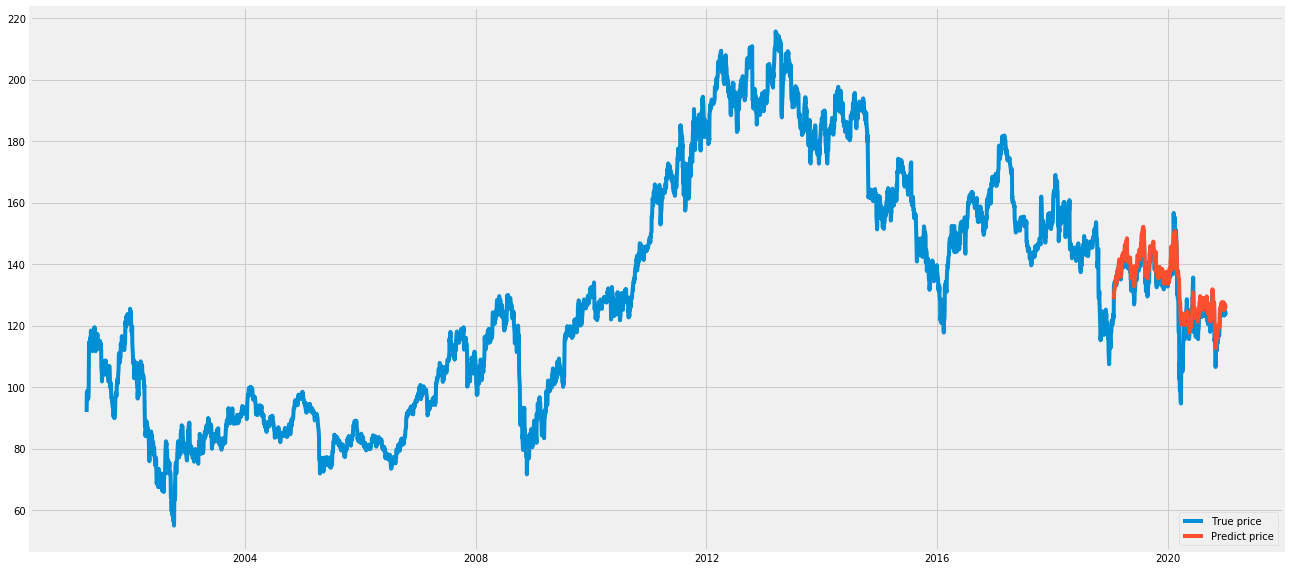

In [22]:
# Biểu đồ tổng quan giá
plt.figure(figsize = (20, 10))
plt.plot(plot_df['Close'])
plt.plot(valid_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

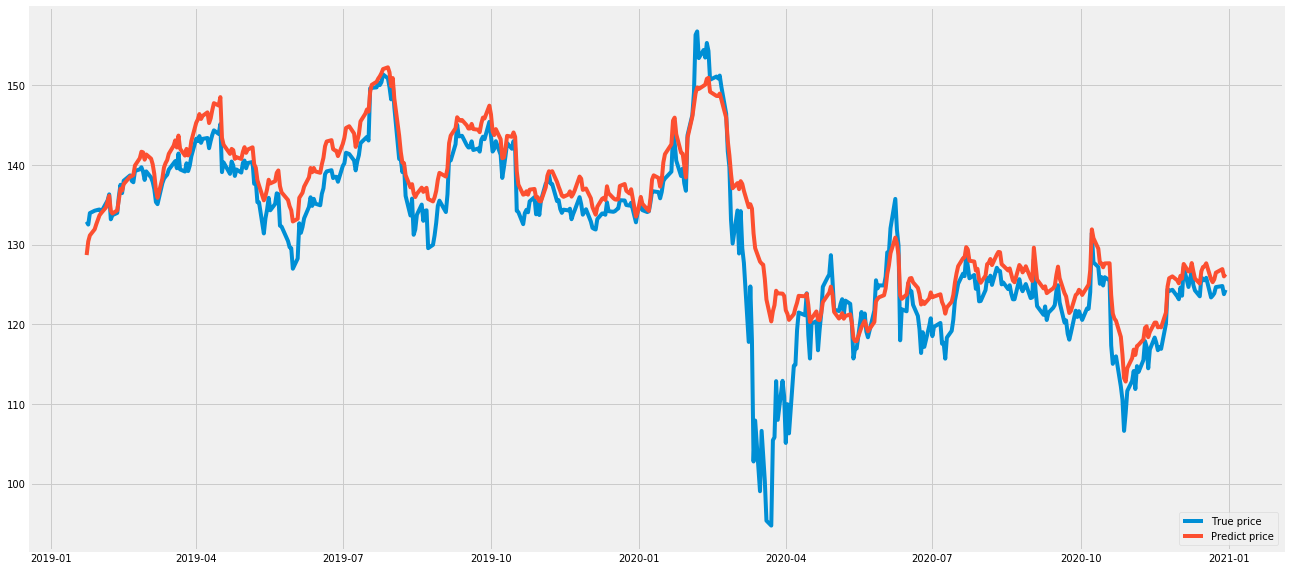

In [23]:
# Biểu đồ riêng giá predict trên tập test và giá thực tế
plt.figure(figsize = (20, 10))
plt.plot(valid_df['Close'])
plt.plot(valid_df['predictions'])
plt.legend(['True price', 'Predict price'], loc = 'lower right')
plt.show()

**Có vẻ như model làm khá tốt việc dự đoán trend và hướng, còn về giá chính xác thì không tốt cho lắm**

## 4. Kết luận:

Đầu tiên nhóm xin được trích dẫn câu nói "All models are wrong, but some are useful" nổi tiếng của giáo sư người Anh George E. P. Box - ông nổi tiếng trong lĩnh vực khoa học thống kê trong thế kỉ 20. Vậy nên cũng không nên đặt hi vọng nhiều.

Tuy đã có nhiều tiến bộ trong lĩnh vực học máy nhưng dự đoán giá cổ phiếu vẫn còn là điều ít mô hình có thể hoàn thành tốt được.

Như kết quả ở trên, bằng việc khảo sát giá và chỉ số EMA trong 60 ngày trước đó, sử dụng mô hình mạng LSTM và mạng Dense thì model hoạt động khá tốt với rmse 3.9. Hơn nữa, nhóm đã đi sâu hơn và khảo sát tỉ lệ hướng dự đoán của mô hình cũng như có một thí nghiệm nhỏ xem độ hiệu quả của mô hình. Với 61% hướng dự đoán chính xác và hơn 400 ngày "ròng rã" mua bán thì lời khoảng 244\\$. Đây là một thành công rất lớn dành cho nhóm vì nó vượt xa mong đợi của nhóm là không lỗ (tưởng tượng đây là 1 con bot). Điều này mở ra cơ hội cho những mô hình mới cải tiến, biết đâu một ngày nào đó bằng sức mạnh máy học có thể chinh phục được điều không tưởng :) (đơn giản là nó đã làm được điều không tưởng trong vài chục năm trước).

## 5.Nguồn tham khảo:
[Stock Price Prediction Using Python & Machine Learning](https://www.youtube.com/watch?v=QIUxPv5PJOY)